# Week 4 Individual Coding Assignment
### Carolyn Chu

This week's homework reviews and improves some of my past assignments as well as expands on this week's isochrone map lab. I have divided my homework into these two sections.

## Section 1: Improving Past Maps

This section contains maps from last week's census data exploration assignment that I've improved upon. I looked at "Median Household Income in the Past 12 Months (in 2019 Inflation-adjusted Dollars)" from American Community Survey 5-year estimates (2015-2019) from censusreporter.org. 

In [1]:
# import the libraries I'm planning to use
# import pandas, geopandas, contextily and matplotlib

import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import folium

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# importing just the household income data for now

hhinc = gpd.read_file('data/acs2019_5yr_medianincome.geojson')

In the last homework assignment, I broke down each individual step to rename columns (including .info() and list) but have decided to just keep the most essential code so that my notebook is a little cleaner.

In [3]:
# renaming columns to names that make sense, including Median Household Income and Margin of Error

hhinc.columns = ['geoid', 'name', 'Median Household Income', 'Margin of Error', 'geometry']

### Choropleth Map
I had some trouble last week with choropleth maps so I went to office hours. Matplotlib wasn't differentiating bins so Chris suggested using folium.

In [4]:
# separate by quantiles
bins = list(hhinc["Median Household Income"].quantile([0, 0.25, 0.5, 0.75, 1]))

# centering the map on LA's coordinates
m = folium.Map(location=[34.051850, -118.243322], tiles=None)

folium.raster_layers.TileLayer(
    location=[34.051850, -118.243322],
    tiles='cartodbpositron',
    attr='Mapbox',
    name='choropleth',
    zoom_start=2
).add_to(m)

#create choropleth
folium.Choropleth(
    geo_data=hhinc,
    data=hhinc,
    columns=['geoid', 'Median Household Income'],
    fill_color='YlGnBu',
    key_on='feature.properties.geoid',
    fill_opacity=0.5,
    line_opacity=0.5,
    legend_name='Median Household Income ($)',
    bins=bins,
    reset=True
).add_to(m)

m

This looks much better than what I was attempting last week when matplotlib was creating one massive census tract. This map helps to show that West LA has some of the highest household incomes whereas Downtown, East, and South LA have some of the lowest median household incomes. The quantiles look a bit funny to me, so just to double check, I'll run some stats...

In [5]:
# get some basic statistics on median household income
hhinc['Median Household Income'].describe()

count       993.000000
mean      68197.410876
std       36624.331957
min        9191.000000
25%       42766.000000
50%       58576.000000
75%       85262.000000
max      250001.000000
Name: Median Household Income, dtype: float64

The quantiles above match the quantiles in the legend on the map so it all checks out!

### Top 10 Census Tracts by Median Household Income 
Last week, I was able to isolate just the top 10 census tracts with highest median incomes, but this week I am adding a basemap to give some context for where these tracts are located.

In [6]:
# sort data by descending values and then just clip the top 10 census tracts into a new variable
hhinc_topten = hhinc.sort_values (by= 'Median Household Income', ascending = False)
hhinc_topten = hhinc_topten.head(10)

In [7]:
# reproject the geodataframe to Web Mercator (epsg: 3857)
hhinc_mercator = hhinc_topten.to_crs(epsg=3857)

Map it!

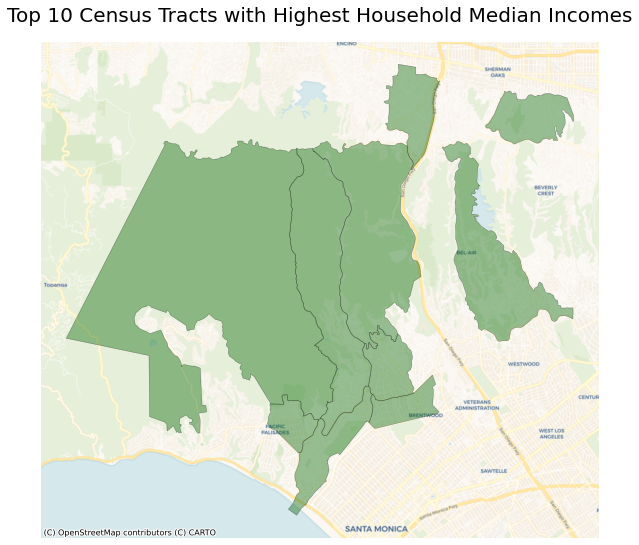

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

# add the layer with ax=ax in the argument 
hhinc_mercator.plot(ax=ax,
                    color="darkgreen",
                    alpha=0.4,
                    edgecolor = 'black',
                    linewidth=0.5
                   )

# turn the axis off
ax.axis('off')

# set a title
ax.set_title('Top 10 Census Tracts with Highest Household Median Incomes',fontsize=20,pad=20)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Voyager)

This correlates with the choropleth map above that the wealthiest census tracts are West LA north of Santa Monica and nearby UCLA.

## Part 2: Isochrone Maps

I'll use the most recent lab to create some isochrone maps to show walksheds. We know that people are more likely to use parks that are within a 10 minute walking distance from their residence so these maps are useful to our research inquiry.

First, I'll add the other libraries I need for isochrone maps.

In [9]:
# for network analysis
import networkx as nx

# for street network analysis
import osmnx as ox

In [10]:
# configure the place, network type, trip times, and travel speed
address = 'Lafayette Recreation Center, Los Angeles, CA, USA'
network_type = 'walk'
trip_times = [5, 10, 15, 20] # in minutes
meters_per_minute = 65 # travel distance per minute, lowered this number from the lab demo

I have decided to focus specifically on Lafayette Park for the purposes of this assignment. I also lowered the travel distance per minute to account for slower walkers.

In [11]:
%%time
# using the magic command %%time to see how long it takes this cell to run 

# download the street network
G = ox.graph_from_address(address, network_type=network_type, dist = 2000)

CPU times: user 5.78 s, sys: 107 ms, total: 5.89 s
Wall time: 5.9 s


That didn't take as long as it took in class! Now, I'm going to make a quick plot to visualize the data.

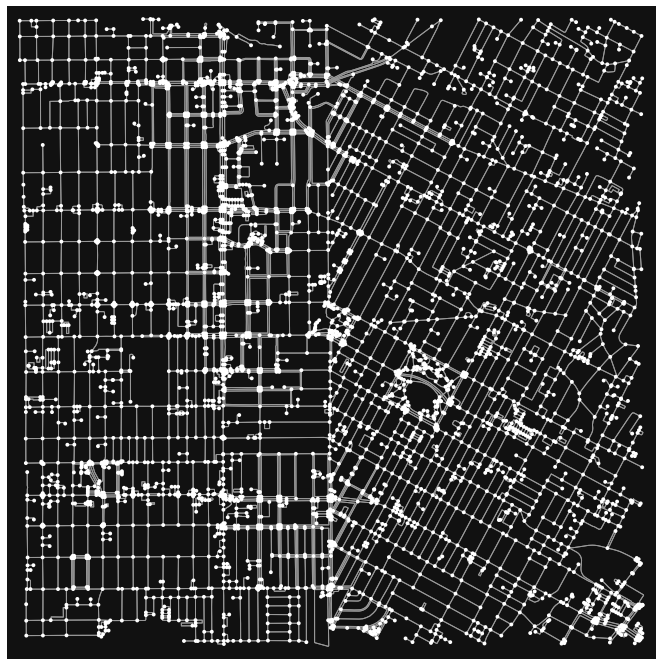

In [12]:
# quick plot using oxmnx
fig, ax = ox.plot_graph(G,figsize=(12,12))

I can see the outlines of the MacArthur/Westlake area, especially that arch walkway in MacArthur Park just southeast of Lafayette Park. There are some really big clusters of nodes all around this area! Next, I'm going to use a projected coordinate system.

In [13]:
# project our network data to Web Mercator (measurements are in meters)
G = ox.project_graph(G, to_crs='epsg:3857')

In [14]:
# convert nodes and edges to geodataframes
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

Some general housekeeping of data like converting nodes and edges into geodataframes... Let's see how they look.

<AxesSubplot:>

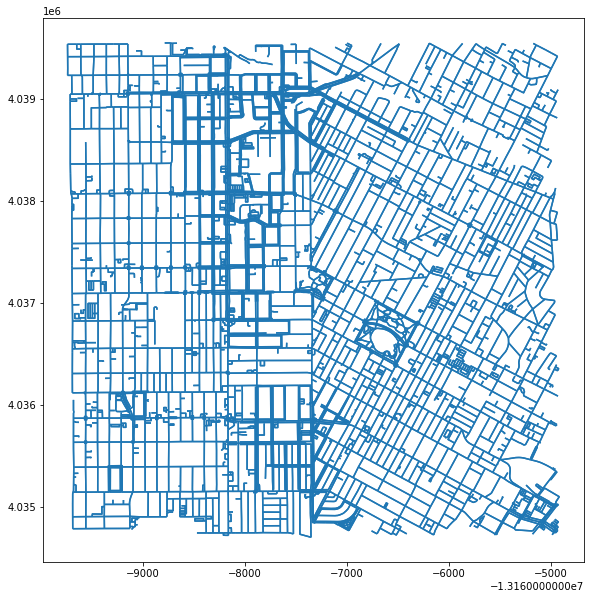

In [15]:
gdf_edges.plot(figsize=(10,10))

<AxesSubplot:>

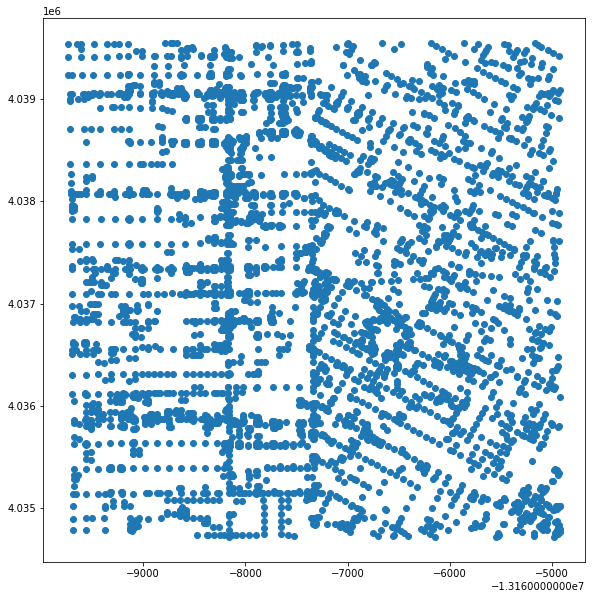

In [16]:
gdf_nodes.plot(figsize=(10,10))

Next, I need to get the centroid to conduct isochrone mapping...

In [17]:
# get the bounding box coordinates
minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
print(minx)
print(miny)
print(maxx)
print(maxy)

-13169738.09657004
4034719.017639067
-13164922.838412385
4039549.4591814536


In [18]:
# calculate the centroid
centroid_x = (maxx-minx)/2 + minx
centroid_y = (maxy-miny)/2 + miny
print(centroid_x)
print(centroid_y)

-13167330.467491213
4037134.2384102605


In [19]:
# use osmnx's distance.nearest_nodes command to get the id for the nearest node
center_node = ox.distance.nearest_nodes(G,Y=centroid_y,X=centroid_x)
print('The id for the nearest node is ' + str(center_node))

The id for the nearest node is 2118131598


Mapping the network layers...

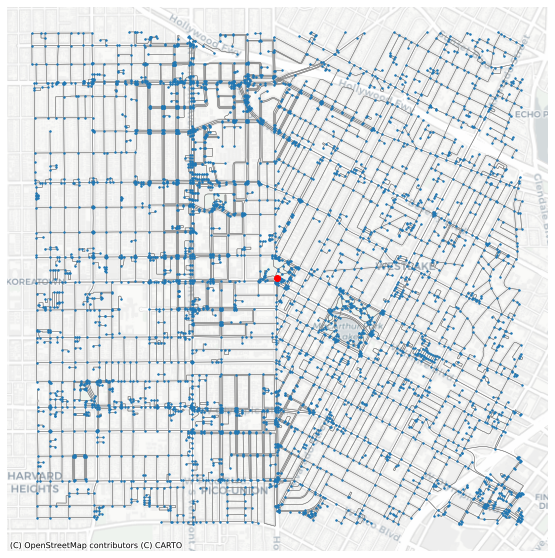

In [20]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               edgecolor='gray', 
               zorder=10)

# add all nodes to ax
gdf_nodes.plot(ax=ax, 
               markersize=2, 
               zorder=20)

# add the center node in red also to ax
gdf_nodes.loc[[center_node]].plot(ax=ax,
                                  color='r', 
                                  zorder=30)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,zoom=14)

Now to calculating travel times and using the colors that Yoh provided in lab...

In [21]:
# create a new column, calculate the time it takes to travel that edge
gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

In [22]:
# assign a color hex code for each trip time isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap='plasma', 
                                start=0, 
                                return_hex=True)
print(trip_times)
print(iso_colors)

[5, 10, 15, 20]
['#0d0887', '#9c179e', '#ed7953', '#f0f921']


In [23]:
# reverse the sort order so that the darker color matches longer times
trip_times.sort(reverse=True)
print(trip_times)
print(iso_colors)

[20, 15, 10, 5]
['#0d0887', '#9c179e', '#ed7953', '#f0f921']


In [24]:
# create a list of "zipped" time/colors
time_color = list(zip(trip_times, iso_colors))
time_color

[(20, '#0d0887'), (15, '#9c179e'), (10, '#ed7953'), (5, '#f0f921')]

I feel like these steps above could be consolidated a better way, so I will need to explore that for the midterm. On to looping and figuring out how many nodes are within a certain distance.

In [25]:
# loop through each trip time and associated color
for time, color in list(time_color):

    # for each trip time, create an egograph of nodes that fall within that distance
    subgraph = nx.ego_graph(G, center_node, radius=time)

    print('There are ' + str(len(subgraph.nodes())) + ' nodes within ' + str(time) + ' minutes ')
    
    # for each of those nodes, update the gdf_nodes dataframe and assign it with its associated distance color
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = str(time) + ' mins'
        gdf_nodes.loc[node,'color'] = color

There are 1151 nodes within 20 minutes 
There are 553 nodes within 15 minutes 
There are 169 nodes within 10 minutes 
There are 41 nodes within 5 minutes 


Make sure all the nodes outside of these distances are colored in as well....

In [26]:
# the NaN values then need to be populated with a valid color
gdf_nodes['color'].fillna('#cccccc', inplace=True)

Map it!

<AxesSubplot:>

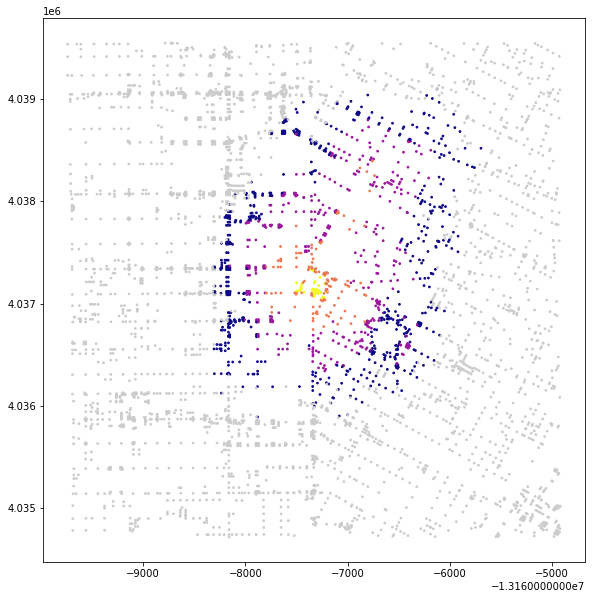

In [27]:
gdf_nodes.plot(figsize=(10,10),
               color=gdf_nodes['color'],
               markersize=3)

Add those edges...

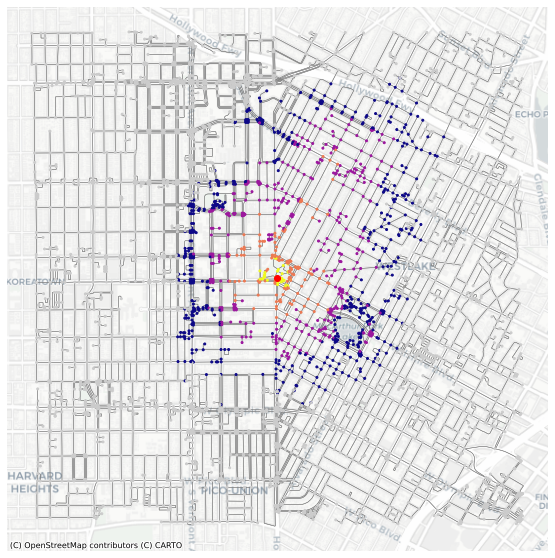

In [28]:
# a "full" map
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               edgecolor='gray', 
               zorder=10)

# add all nodes to ax
gdf_nodes.plot(ax=ax,
               color=gdf_nodes['color'],
               markersize=4, 
               zorder=20)

# add the center node in red also to ax
gdf_nodes.loc[[center_node]].plot(ax=ax,
                                  color='r', 
                                  zorder=30)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,zoom=14)

This dissolve portion is a bit fuzzy to me still, but I think I'm getting it...

In [29]:
# put it in a variable
gdf_5 = gdf_nodes[gdf_nodes['time']=='5 mins']

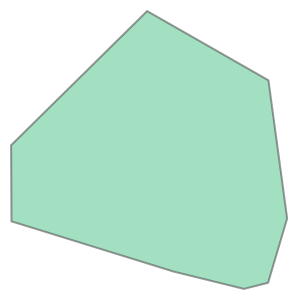

In [30]:
gdf_5.unary_union.convex_hull

In [31]:
# dissolve the nodes by time
isochrones = gdf_nodes.dissolve("time")

In [32]:
# for each row, create a convex hull
isochrones = isochrones.convex_hull.reset_index()

In [33]:
# geometry header has been automatically named "0"
# let's rename that
isochrones.columns=['time','geometry']

<AxesSubplot:>

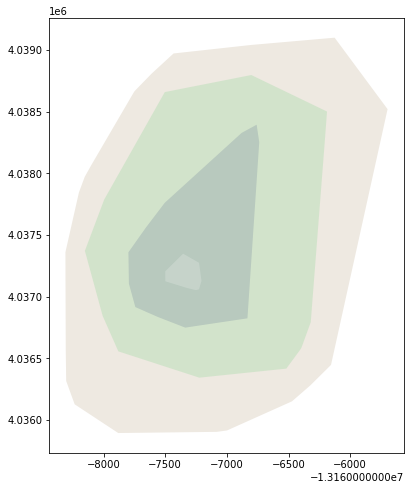

In [34]:
isochrones.plot(figsize=(8,8),alpha=0.2,cmap='terrain')

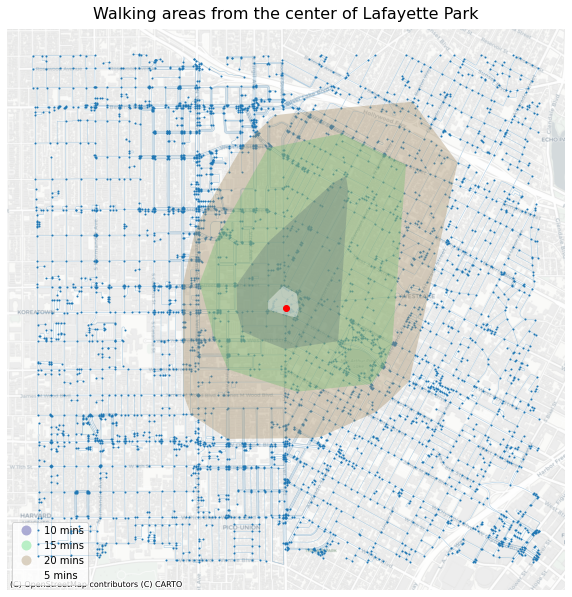

In [35]:
# set up the subplots
fig, ax = plt.subplots(figsize=(10,15))

# add the isochrones
isochrones.plot(alpha=0.4, 
                ax=ax, 
                column='time', 
                cmap='terrain', 
                legend=True,
                zorder=20)

# add the center node in red
gdf_nodes.loc[[center_node]].plot(ax=ax,color='r', zorder=30)

# add all nodes
gdf_nodes.plot(ax=ax, 
               markersize=1, 
               zorder=10)

# add the edges
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               alpha=0.2,
               zorder=10)

# hide the axis
ax.axis('off')

# give it a title
ax.set_title('Walking areas from the center of Lafayette Park',fontsize=16,pad=10)

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

What an interesting shape!